# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [3]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [4]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [7]:
# function that takes raw data and completes all preprocessing required before model fits
#lemmatize
import nltk
from nltk import word_tokenize 
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords', quiet=True, raise_on_error=True)
stop_words = set(nltk.corpus.stopwords.words('english'))
tokenized_stop_words = nltk.word_tokenize(' '.join(nltk.corpus.stopwords.words('english')))

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles) if t not in stop_words]
    
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())
        
    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='ascii', ngram_range=(1,2), lowercase=True, max_df = 0.5, min_df = 10, stop_words=tokenized_stop_words)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['exclam_count'] = movie_data['review'].str.count("\!")
    movie_data['q_count'] = movie_data['review'].str.count("\?")
    movie_data['q_star'] = movie_data['review'].str.count("\*")
    movie_data['q_hash'] = movie_data['review'].str.count("\#")
    
    # uppercase letter count
    import string
    movie_data['upper'] = [sum(1 for letter in c if letter.isupper()) for c in movie_data['review']]
    
    #afinn sentiment dictionary score from modifierd dictionary of only negative sentiment words
    from afinn import Afinn
    afn = Afinn()
    
    movie_data['afinn_score'] = [afn.score(c) for c in movie_data['review']]

    X_quant_features = movie_data[["word_count", "punc_count",'exclam_count','q_count','upper','q_star','q_hash','afinn_score']]
    
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = movie_data['sentiment']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

[nltk_data] Downloading package punkt to /Users/admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Create training and test sets from function

In [9]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=80)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 55755)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         433          20             1        2     59       0       0   
1      

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [10]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 4884, 'TN': 5089, 'FP': 4954, 'FN': 5073, 'Accuracy': 0.49865, 'Precision': 0.49644236633462085, 'Recall': 0.4905091895149141, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [11]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(alpha=5, max_iter=10000)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9809, 'TN': 9873, 'FP': 170, 'FN': 148, 'Accuracy': 0.9841, 'Precision': 0.9829642248722317, 'Recall': 0.9851360851662148, 'desc': 'svm_train'}


### MODEL: logistic regression

In [12]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log',alpha=1)
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9915, 'TN': 10016, 'FP': 27, 'FN': 42, 'Accuracy': 0.99655, 'Precision': 0.9972842486421243, 'Recall': 0.9957818620066285, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [13]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9558, 'TN': 9669, 'FP': 374, 'FN': 399, 'Accuracy': 0.96135, 'Precision': 0.9623439387837294, 'Recall': 0.9599276890629708, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [14]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron',alpha=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9953, 'TN': 10042, 'FP': 1, 'FN': 4, 'Accuracy': 0.99975, 'Precision': 0.9998995378742214, 'Recall': 0.9995982725720599, 'desc': 'prc_train'}


### Model: Neural Network Perceptron

In [10]:
# from sklearn import neural_network

# prc = neural_network.MLPClassifier()
# prc.fit(X_train, y_train)

# prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
# prc_performance_train.compute_measures()
# print(prc_performance_train.performance_measures)

### MODEL: Ridge Regression Classifier

In [15]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=1, normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9957, 'Neg': 10043, 'TP': 9957, 'TN': 10042, 'FP': 1, 'FN': 0, 'Accuracy': 0.99995, 'Precision': 0.9998995782285599, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=1000, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 9957, 'Neg': 10043, 'TP': 9851, 'TN': 10021, 'FP': 22, 'FN': 106, 'Accuracy': 0.9936, 'Precision': 0.9977717005975894, 'Recall': 0.9893542231595862, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

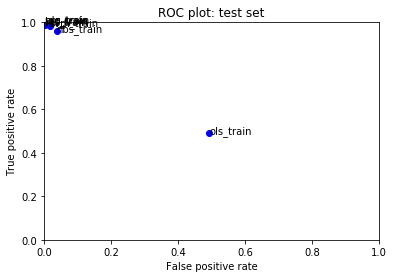

In [17]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [18]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [19]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
113
How a director of Altman's experience could ever expect us to want to spend time with, or to care about what happens to, a lead character who is neurotic, a whiner, a jerk with no redeeming qualities -- that is the central puzzle about this profoundly confused piece of work. A monstrous piece of trash. In addition to this crippling flaw, the plot line requires serious concentration to follow. The setup that the Branagh character walks into is so obviously a setup from the start that we are inclined to wonder whether the writer and director have totally lost respect for their audience. This latter issue is at the core of the film: it represents directorial self-indulgence with profound contempt for the taste, values, and intelligence of the viewer. Very unusual for Mr. Altman.<br /><br />Patrick Watson
* * * * * * * * * 
216
I can't believe this is on DVD. Even less it was available at my local video store.<br /><br />Some argue this is a good movie if y

3036
Trite, clichéd dialog and plotting (the same kind of stuff we saw all through the 1980s fantasy movies), hokey music, and a paint-by-numbers characters knocks this out of the running for all but the most hardcore fans.<br /><br />What saves this film from the junk heap is the beautiful crutch of Bakshi's work, the rotoscoping, and the fact that Frank Frazetta taught the animators how to draw like him. This is Frazetta...in motion. The violence is spectacular and the art direction and animation are unlike any other sword & sorcery movie of the period.<br /><br />I like to watch this with the sound off, playing the soundtrack to the first Conan movie instead.
* * * * * * * * * 
3043
A one is the highest rating I could have given this movie, considering zero and negative numbers are not allowed. Pee yew, pointless mess of a movie with a lot of wasted b-list actors who have done better work, written and directed by some guy with the mentality of a twelve year old who smirks and giggle

6070
someone needed to make a car payment... this is truly awful... makes jean Claude's cyborg look like gone with the wind... this is an hour I wish I could sue to get back... luckily it produced severe somnolence... from which I fell asleep. how can actors of this caliber create this dog? I would rather spend the time watching algae grow on the side of a fish tank than partake of this wholly awful concoction of several genre. I now use the DVD as a coaster on my coffee table. $5.99 at walmart is far too much to spend on this movie... if you really have to have it, wait till they throw them out after they have carried them on the inventory for several years and are frustrated that they would not sell.<br /><br />please for the love of god let this movie die of obscurity.
* * * * * * * * * 
6090
First of all, let's get a few things straight here: a) I AM an anime fan- always has been as a matter of fact (I used to watch Speed Racer all the time in Preschool). b) I DO like several B-Mov

8985
I can't figure Al Pacino out. I watch him in the Godfather, Scarface, Carlito's Way, and I think I am watching one of the greatest actors of the last thirty years. Then I see him in Two for the Money, Any Given Sunday and Revolution, and I wonder what the guy is thinking.<br /><br />I stumbled on Revolution a few nights ago, and thought I would invest the next two hours on this. Here is a news flash: Want to get prisoners to talk? Force them to watch this over and over...they'll confess to anything.<br /><br />I won't rehash the plot since there is no coherent plot, but it does take place during the American Revolution and Pacino plays an uneducated peasant who does not want to get involved, but ultimately does. While he has no money, no education and dresses like a caveman, a very hot Natasha Kinski falls in love with him for no apparent reason, since they have only two minutes of dialogue together.<br /><br />Quite frankly, if \Al Smith\" starred in this movie, instead of \"Al P

11783
ET's obsession with Dannielynn Smith is despicable. Leave the child alone. With all the constant attention she'll most likely grow up psychotic, depressed or worse. Think of Princess Diana and how she longed for privacy. Now poor little rich girl Ashley Olson just wants to be left alone. No wonder Greta Garbo became a recluse and said \I want to be alone\". How much does ET make off this little girl? Does ET not have anything better to report on? I bet there's lots of people who really don't care what color her birthday cake and balloons were. By the way, I never heard that Anna Nichole ever won any of those court cases over the will and her inheritance. Who is paying for the lifestyle of Larry, Howard and little Dannielynn? Could it be ET?"
* * * * * * * * * 
11800
The directors cut version, which was the one I saw, was very long for this type of movie. Almost two hours is way too long. If you have the choice, definitely go for the non-directors cut.<br /><br />The main plot is 

14806
The problem I find with this title is that I am not sure if the director is trying to produce a documentary or movie. A blend of the two genres just doesn't work and that leaves the whole thing hung in the middle of nowhere. This is more so as the director has picked the most extremes of what is supposed to be happening around our everyday life making it an unconvincing documentary. If it is meant to be a thriller/drama this is too dull and monotonous. In either case, what is the moral or the message which the director is trying to convey to the audience? That around us there are people who ill-treat others who are willing to be ill-treated? That there are many crazy lunatics around us? So..........so what?
* * * * * * * * * 
15150
Three story lines and not enough tying them together, \Inside Man\" was very jumpy and an incomplete attempt to be artistic and realistic. Though having its moments, the movie started off looking like a fast thriller which quickly grounded to a slow cr

18480
The premise is amazing and the some of the acting, notably Sally Kellerman and Anthony Rapp, is charming... but this film is near unwatchable. The music sounds as if it comes from some sort of the royalty free online site and the lyrics as if they were written with a rhyming dictionary open on the lap. Most of the singing is off-key. I think they may have filmed with the singing accapella and put in the music under it... The dialogue is really stupid and trite. The movie works best when it is actually talking about the real estate but unfortunately it strays to often into stupid farcical sub-plots. I found myself checking my watch after ther first twenty minutes and after 40 wondering 'when is it ever going to end.'
* * * * * * * * * 
18520
I'm not even gonna waste time on this one; it's not funny, not scary, practically unwatchable and only occassionaly gory(the FX suck though(no pun intended)). This is a disclaimer; WATCH AT YOUR PERIL! Ask yourself 1 question; Are slugs scary?

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [20]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1285, 'TN': 1240, 'FP': 1217, 'FN': 1258, 'Accuracy': 0.505, 'Precision': 0.5135891286970423, 'Recall': 0.5053086905230043, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [21]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2306, 'TN': 2186, 'FP': 271, 'FN': 237, 'Accuracy': 0.8984, 'Precision': 0.8948389600310438, 'Recall': 0.9068029885961463, 'desc': 'svm_test'}


### MODEL: logistic regression

In [22]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2279, 'TN': 2206, 'FP': 251, 'FN': 264, 'Accuracy': 0.897, 'Precision': 0.9007905138339921, 'Recall': 0.8961856075501377, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [23]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2174, 'TN': 2138, 'FP': 319, 'FN': 369, 'Accuracy': 0.8624, 'Precision': 0.8720417168070598, 'Recall': 0.854895792371215, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [24]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2168, 'TN': 2103, 'FP': 354, 'FN': 375, 'Accuracy': 0.8542, 'Precision': 0.8596352101506741, 'Recall': 0.852536374360991, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [25]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 2218, 'TN': 2171, 'FP': 286, 'FN': 325, 'Accuracy': 0.8778, 'Precision': 0.8857827476038339, 'Recall': 0.8721981911128588, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [26]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2543, 'Neg': 2457, 'TP': 1783, 'TN': 2100, 'FP': 357, 'FN': 760, 'Accuracy': 0.7766, 'Precision': 0.8331775700934579, 'Recall': 0.7011403853716084, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

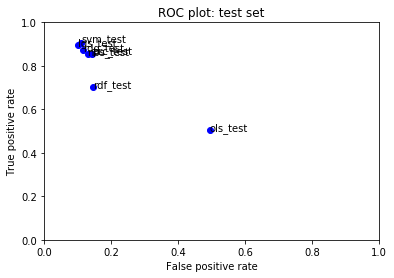

In [27]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [28]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='moviereviews_test.tsv', my_random_seed=80, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 55755)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclam_count  q_count  upper  q_star  q_hash  \
0         131           5             0        0      7       0       0   
1         169          15             1        0     15       0       0   
2         176          18             0        0     25       0   

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [29]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = svm.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.49776


In [30]:
raw_data.head()

,id,review,word_count,punc_count,exclam_count,q_count,q_star,q_hash,upper,afinn_score
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0,0,0,0,7,17.0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1,0,0,0,15,22.0
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0,0,0,0,25,7.0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0,0,0,0,10,10.0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0,0,0,0,17,3.0


In [31]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [32]:
my_submission.shape

(25000, 2)

In [33]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation